In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math

#from src.edges_and_fitting import *
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
def grad(mode):
    if mode=='fd':
        gx = np.array([[0,0,0],[-1,0,1],[0,0,0]])
        gy = gx.T
        g = np.dstack((gx,gy))
    if mode=='sobel':
        gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        gy = gx.T
        g = np.dstack((gx,gy))
    if mode=='laplacian':
        gx = np.array([[1,1,1],[1,8,1],[1,1,1]])
        gy = gx.T
        g = np.dstack((gx,gy))
    return g

def get_im2col_indices(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)



def conv2d(im,g,stride=1,C=3):
    im = np.repeat(im[np.newaxis,:,:],2,axis=0)

    g = np.moveaxis(g,2,0)
    
    im = im[:,np.newaxis,:,:]
    N,_,H,W = im.shape
    _,h,w = g.shape
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    k,i,j = get_im2col_indices((N,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

    im_padded = np.pad(im,((0,0),(0,0),(h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[:,k,i,j]
    

    g = g.reshape((N,-1))

    
    sol = np.squeeze(np.matmul(g[:,np.newaxis,:],cols))
    
    return sol.reshape(N,H,W)

def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))

In [3]:
def Reduce(im,k):
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

In [4]:
class canny1:
    def __init__(self,img,th=0.1,blur=True,h=3,w=3,sig=1,sharp=False,deriv_type='fd',Red=0):
        im = plt.imread(img)
        im = Reduce(np.mean(im,axis=2),Red)
        if sharp==True:
            g = np.array([[1,1,1],[1,-9,1],[1,1,1]])
            g = np.dstack((g,g.T))
            im = conv2d(im,g)[0]
        
        if blur==True:
            G = GaussianFilter(h,w,sig)
            G = np.dstack((G,G))
            im = conv2d(im,G)[0]
        
        g = grad(deriv_type)
        R = conv2d(im,g)
        S = np.sqrt(np.sum(R**2,axis=0))
        plt.imshow(S,**{'cmap':'gray'})
        plt.show()
        mask = (S-S.min())/(S.max()-S.min())
        mask[mask>=th] = 1
        mask[mask<th] = 0

        rho = np.arctan2(R[1],R[0])
        rho[rho<0]+= 2*math.pi

        n=np.divide(R,S[np.newaxis,:,:],out=np.zeros_like(R),where=S!=0)
        n*=mask
        self.n = n
        self.S = S*mask
        self.nonMaxSup()
        
    def nonMaxSup(self):
        n = self.n
        S = self.S
        S_padded = np.pad(S,((1,1),(1,1)),'mean')
        kp = np.argwhere(S)

        n0 = n[:,kp[:,0],kp[:,1]].T

        q0 = kp+n0*1/(2*math.sin(math.pi/8)) 
        q1 = kp-n0*1/(2*math.sin(math.pi/8)) 

        q0 = np.round(q0).astype(int)
        q1 = np.round(q1).astype(int)

        maxs = (S[kp[:,0],kp[:,1]]>S_padded[q0[:,0],q0[:,1]])& (S[kp[:,0],kp[:,1]]>S_padded[q1[:,0],q1[:,1]])

        maxs = kp[maxs]
        new_S = np.zeros_like(S)
        new_S[maxs[:,0],maxs[:,1]]=1
        self.mask = new_S
        plt.imshow(new_S,**{'cmap':'gray'})

In [5]:
import time

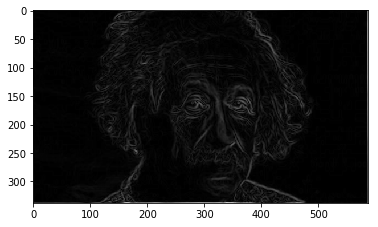

0.549485445022583


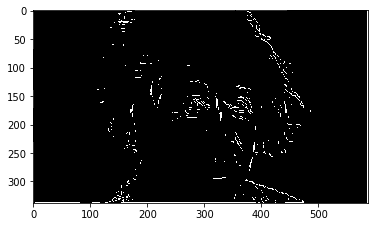

In [6]:
start = time.time()
im1 = canny1('img/ein.jpeg',deriv_type='fd',sharp=False,
             blur=True,h=3,w=3,sig=1,th=.15,Red=1)
end = time.time()
print((end-start))

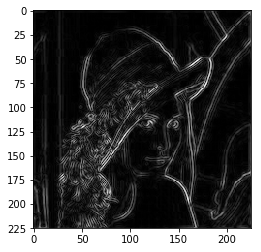

0.39803218841552734
 

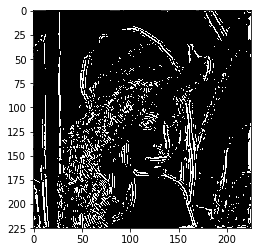

In [7]:
%%prun
start = time.time()
im1 = canny1('img/canny.jpeg',deriv_type='fd',sharp=True,
             blur=True,h=3,w=3,sig=1,th=.1,Red=0)
end = time.time()
print((end-start))

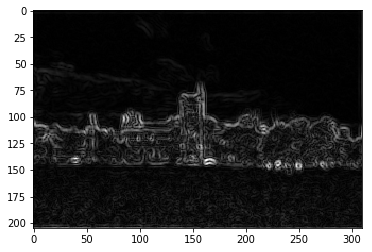

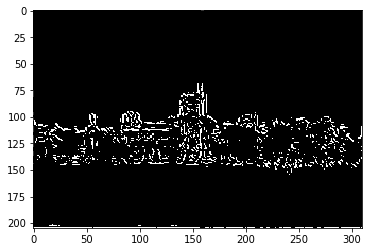

In [8]:
im1 = canny1('img/uoft4.jpg',deriv_type='fd',sharp=True,
             blur=True,h=5,w=5,sig=5/3,th=.2,Red=4)

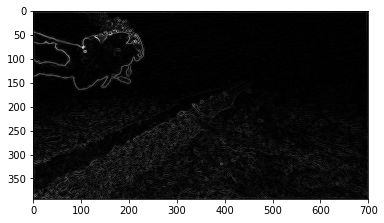

1.0591461658477783
 

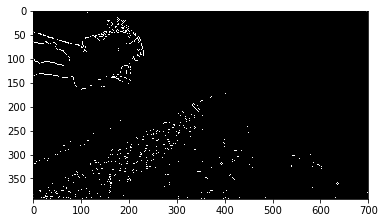

In [9]:
%%prun
start = time.time()
im1 = canny1('img/underwater-pipeline.jpg',deriv_type='fd',sharp=True,
             blur=True,h=5,w=5,sig=1.5,th=.15,Red=0)
end = time.time()
print((end-start))

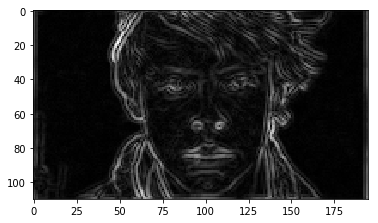

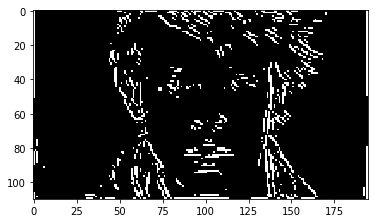

In [10]:
im1 = canny1('img/luke.jpg',deriv_type='fd',sharp=True,
             blur=True,h=3,w=3,sig=3,th=.2,Red=2)

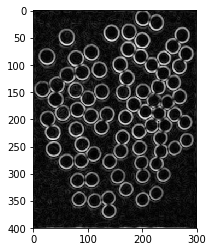

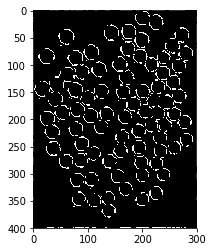

In [11]:
im1 = canny1('img/coins1.jpg',deriv_type='fd',sharp=True,
             blur=True,h=11,w=11,sig=2,th=.3,Red=2)